In [1]:
import mysql.connector
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.0f}'.format

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns

import re

import time
import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
# matplot 한글 설정
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

if platform.system() == "Darwin": # MAC
    rc("font", family = "Arial Unicode MS")
    print("Hangul Setting OK for Mac")

elif platform.system() == "Windows": # WINDOW
    print("Fail : Window Hangul setting have to custom this section")
    raise

else: # COLAB
    plt.rc('font', family='NanumBarunGothic') 
    print("Hangul Setting OK for Colab")
    
plt.rcParams["axes.unicode_minus"] = False

Hangul Setting OK for Mac


In [3]:
# Mysql 초기화
def init_mysql():
    aws = mysql.connector.Connect(
        database = 'df',
        host = "ENTER DB HOST",
        port = 3306,
        user = 'sold_table',
        password = '1234'
    )
    return aws

In [4]:
# Pandas read_sql함수 사용하여 DB에서 데이터프레임 형태로 데이터 가져오기
def db_get_data(query):
    aws = init_mysql()
    df = pd.read_sql(query, aws)
    aws.close()
    return df

In [5]:
# 등록, 판매 기록 데이터 가져오기
def get_regi_df():

    query = "select distinct * from ticket_history where itemName like '%입장권%';"
    df = db_get_data(query)

    return df

def get_sold_df():

    query = "select distinct * from sold_history where itemName like '%입장권%';"
    df  = db_get_data(query)

    return df


In [6]:
# DB 데이터 가져오기
sold_history = get_sold_df()
regi_history = get_regi_df()

In [7]:
# 데이터 수 확인
len(sold_history), len(regi_history)

(65644, 60584)

In [8]:
# 데이터 분석에 사용할 칼럼 필터링
regi_df = regi_history[['auctionNo', 'regDate', 'itemId', 'itemName', 'count', 'unitPrice']]

sold_df = sold_history[sold_history.columns]

In [9]:
# 타입 변경
sold_df['soldDate'] = pd.to_datetime(sold_df['soldDate'])
sold_df = sold_df.set_index('soldDate').sort_index()

regi_df['regDate'] = pd.to_datetime(regi_df['regDate'])
regi_df = regi_df.set_index('regDate').sort_index()


datasets = [regi_df, sold_df]

for data in datasets:
    data['unitPrice'] = data['unitPrice'].astype('int')
    data['count'] = data['count'].astype('int')


## 전체 비교

In [10]:
# X축 이름 축소를 위한 함수
def rename_xticks(col):

    if col == '':
        print('Get blank String')   
        return col

    if '마스터' in col:
        rename = re.sub('마스터', 'M', col)
    elif '익스퍼트' in col:
        rename = re.sub('익스퍼트', 'E', col)
    elif '노멀' in col: 
        rename = re.sub('노멀', 'N', col)

    
    return re.sub('(입장권)','', rename)

In [11]:
# 던전별 입장권 판매 등록, 완료 데이터 시각화
def print_tickets(sold_df, regi_df, plt_title = ''):
    # 경매장 판매
    sold_tmp = sold_df[['unitPrice', 'itemName']]
    sold_tmp['hue'] = '판매'

    # 경매장 등록
    regi_tmp = regi_df[['unitPrice', 'itemName']]
    regi_tmp['hue'] = '등록'

    # 그래프 그려줄 데이터
    hist_df = pd.concat([sold_tmp, regi_tmp])
    hist_df['itemName'] =  hist_df['itemName'].apply(rename_xticks) # X축 표시를 위한 이름 축소

    #그래프 그리기
    plt.figure(figsize=(30,10))
    sns.set_palette("Paired")
    sns.countplot(data = hist_df, x = 'itemName', hue = 'hue', order = hist_df['itemName'].value_counts().index)

    #라벨 제거
    plt.xlabel('')
    plt.ylabel('')

    #제목 설정
    if plt_title == '':
        plt.title('입장권별 경매장 등록/판매 수량', fontsize= 30, pad = 15)
    else:
        plt.title(plt_title, fontsize= 30, pad = 15)

    # 축 설정
    if len(hist_df['itemName'].unique()) > 5: # X축 레이블이 5개 이상이면 이름 45도 회전
        plt.xticks(rotation = 45)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)

    #범주 설정
    plt.legend(prop={'size':25})

    plt.show()

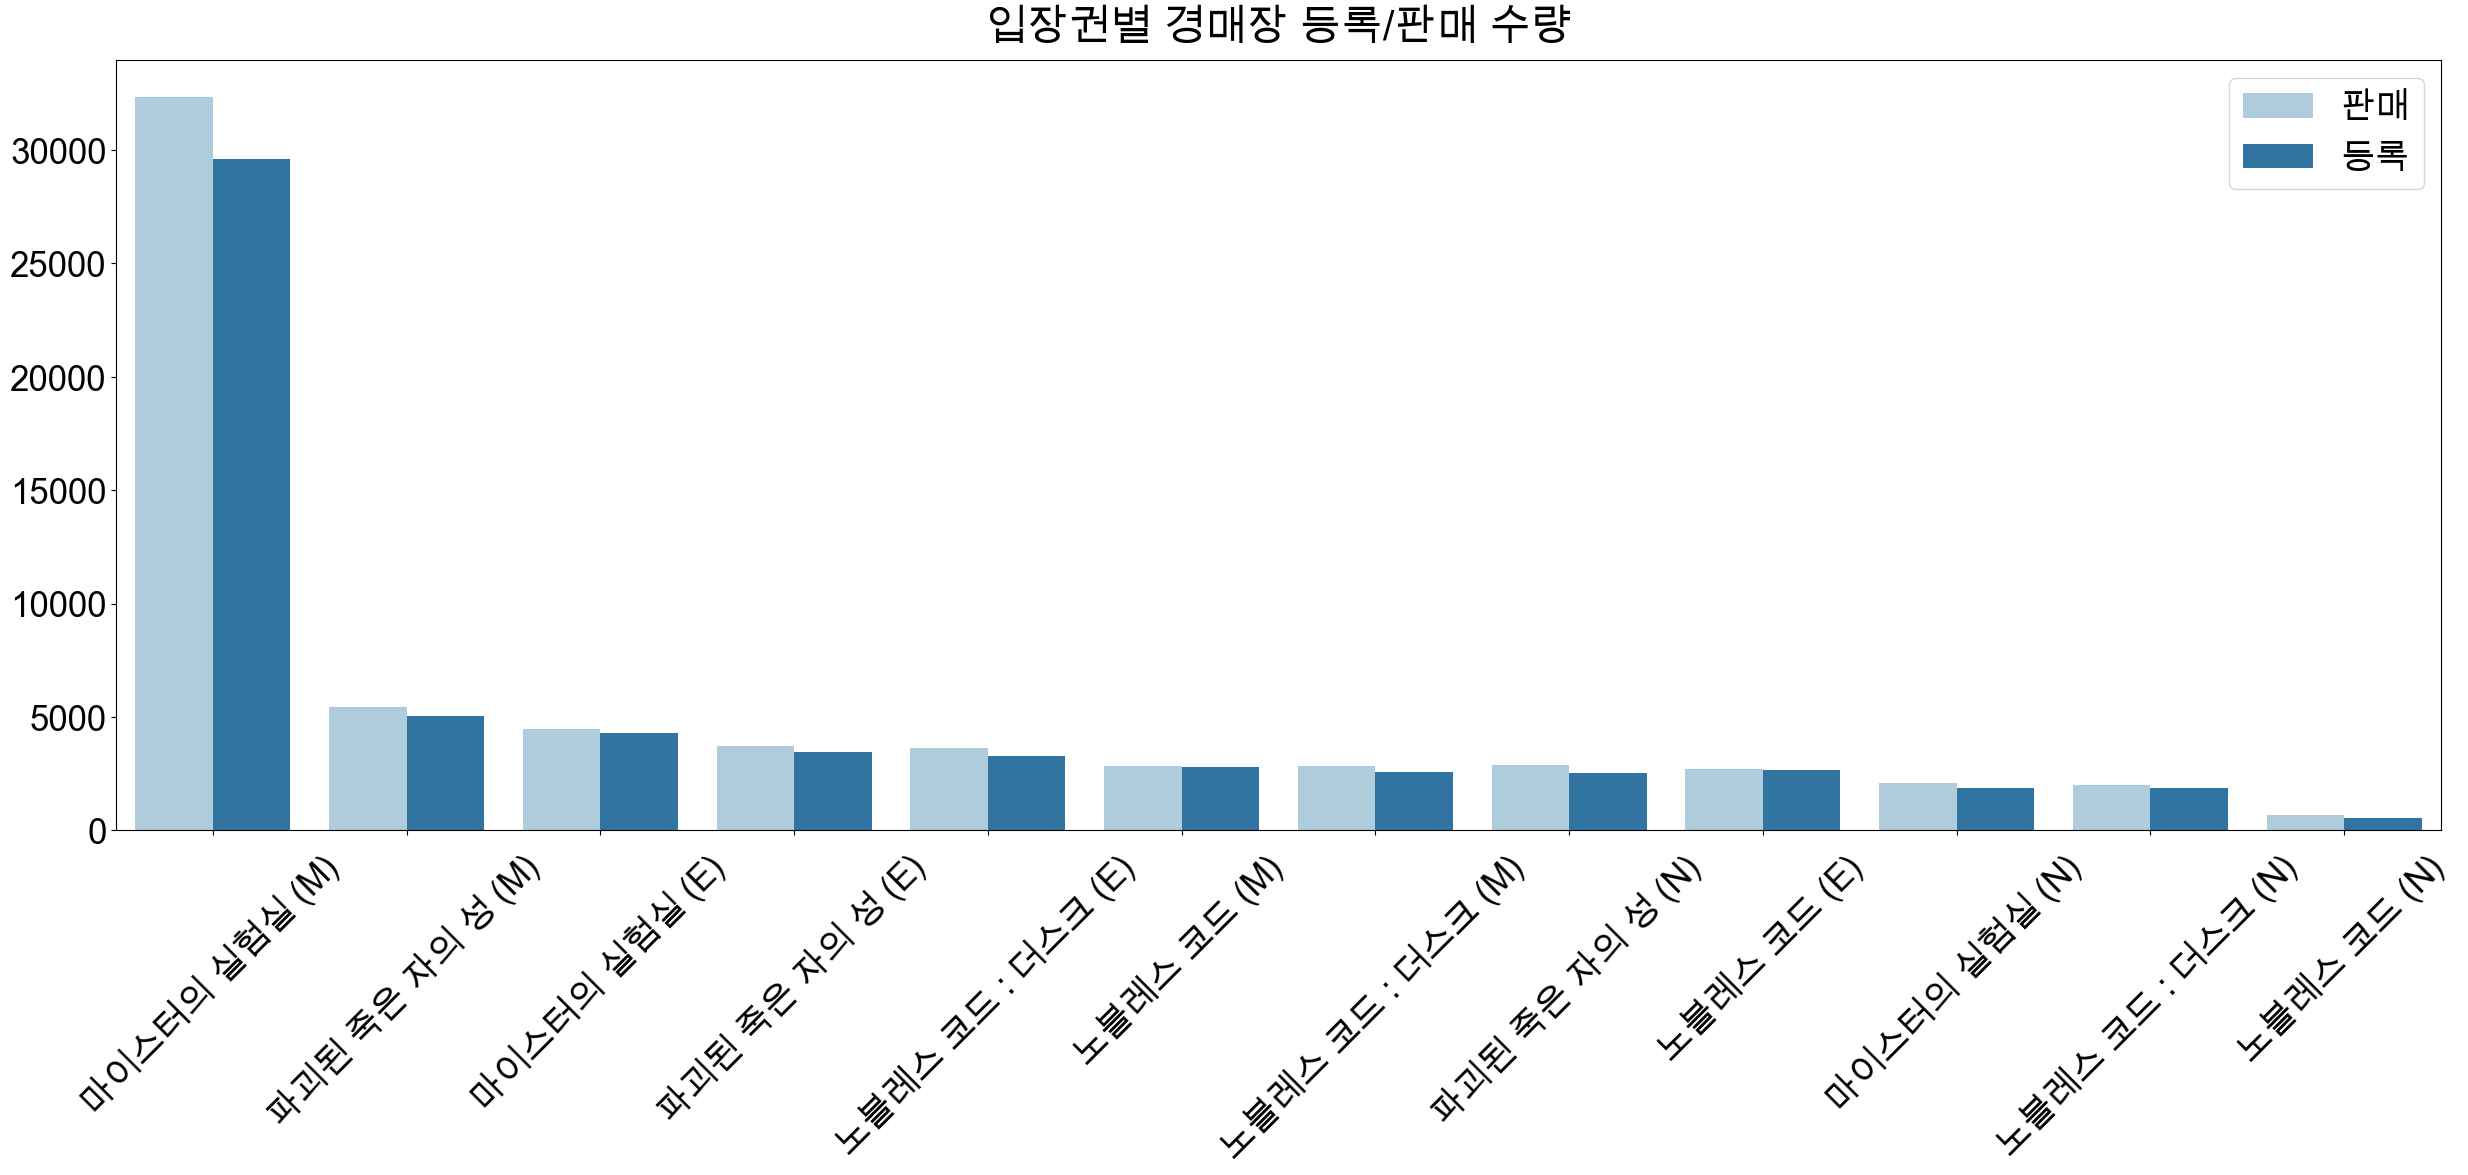

In [12]:
print_tickets(sold_df, regi_df)

In [14]:
# 입장권별로 데이터 분리
trade_types = ["regi", 'sold']
ticket_dfs = {trade_type : [] for trade_type in trade_types}

for name in sold_df['itemName'].unique():
    for trade_type in trade_types:
        
        # 등록인지 판매인지 구분
        if trade_type == 'regi':
            df = regi_df
        elif trade_type == 'sold':
            df = sold_df

        # 거래 타입에 맞춰 해당 데이터프레임에서 입장권 데이터 분리
        target = df[df['itemName'] == name]
        ticket_dfs[trade_type].append({name : target})

        # 각 입장권의 등록, 판매 수량 출력
        # print(f"{trade_type} {name}, : ",len(target))
    # print()

## 마이스터 실험실 마스터 입장권 분석

### 가격 분포

In [15]:
def print_ticket_hist(df_num):
    
    df_key = list(ticket_dfs['regi'][df_num].keys())[0] # itemName정보 가져오기 key값으로 들고있음.

    # 마이스터 실험실 마스터 입장권 경매장 등록, 판매 데이터 중 가격에 대한 정보만 가져오기
    regi_hist = ticket_dfs['regi'][df_num][df_key][['unitPrice']] 
    sold_hist = ticket_dfs['sold'][df_num][df_key][['unitPrice']]

    # 그래프 그리기
    fig, ax1 = plt.subplots(figsize=(20,10))

    # 등록그래프
    sns.histplot(regi_hist['unitPrice'], color='r', alpha=0.2, label='판매등록', ax = ax1)

    # X축 공유하는 그래프
    ax2 = ax1.twinx()
    sns.histplot(sold_hist['unitPrice'], color='b', alpha=0.2, label='판매완료', ax = ax2)

    # 제목 추가, 라벨 표시 형태 설정
    plt.title(df_key + " 등록/판매 분포" , fontsize=20, pad = 15)
    plt.ticklabel_format(axis='x',useOffset=False, style='plain')

    # x,y 축 이름 제거
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax2.axis('off')

    # 폰트 크기 설정
    ax1.tick_params(axis='both', which='major', labelsize=15)

    # 범례 추가
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, fontsize=15)

    plt.show()

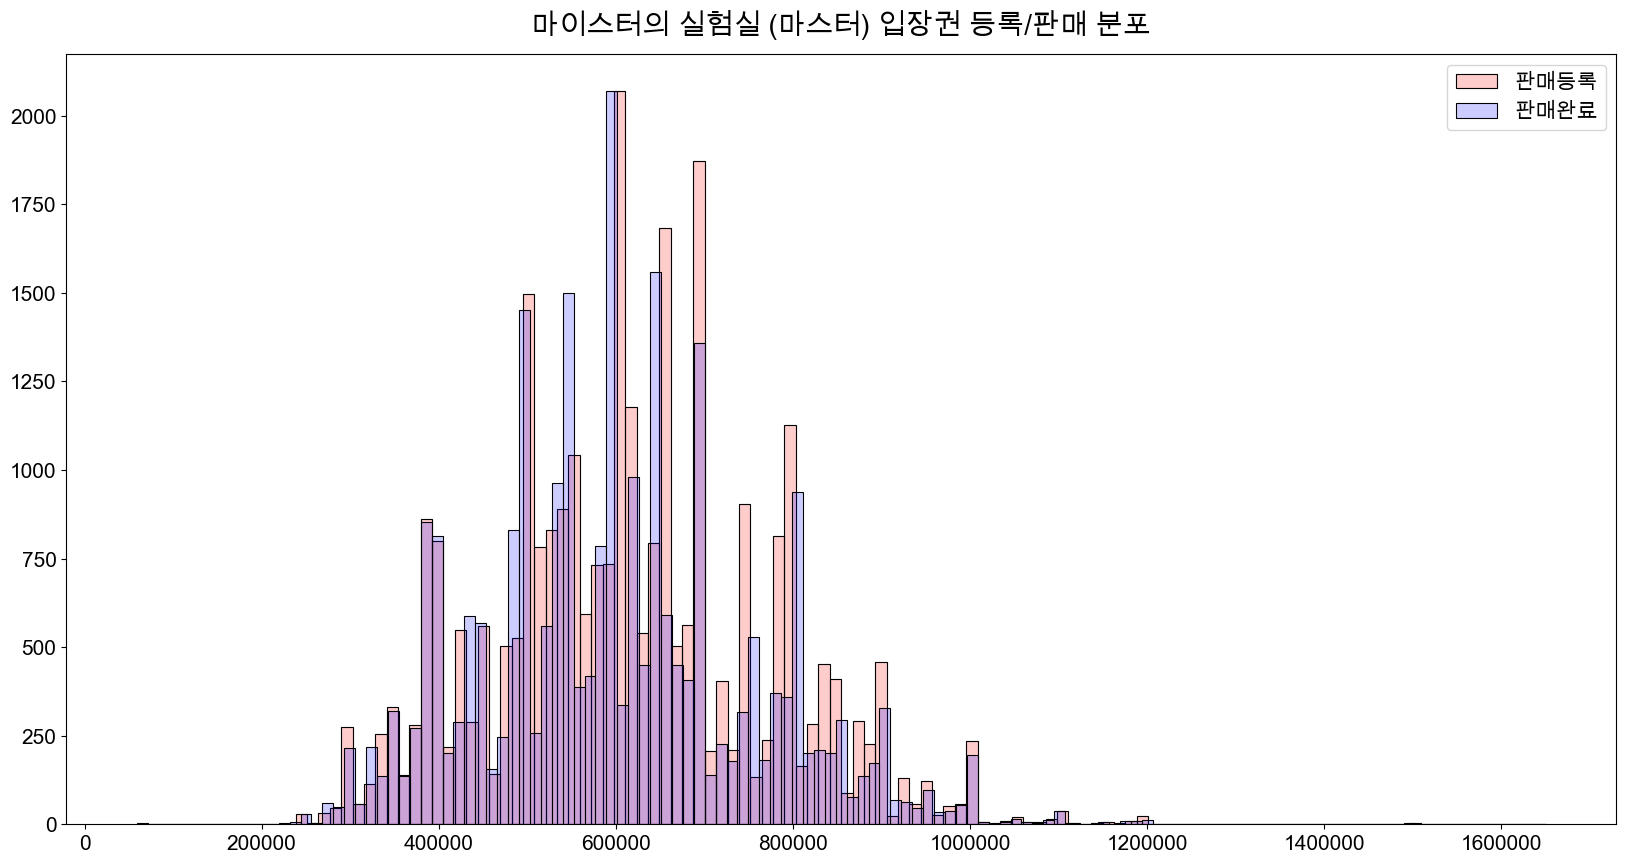

In [16]:
print_ticket_hist(11) # 분리한 데이터 프레임중 12번째(11)가 마이스터 실험실 마스터 데이터.

### 가격 흐름

#### 경매장 등록/판매 흐름(가격, 수량)

In [17]:
def print_ticket_lineplot(df_num, trade_type):

    df_key = list(ticket_dfs['regi'][df_num].keys())[0] # itemName정보 가져오기 key값으로 들고있음.

    if trade_type == 'regi':
        df = ticket_dfs['regi'][df_num][df_key]
        title_keyword = '등록'
    elif trade_type == 'sold':
        df = ticket_dfs['sold'][df_num][df_key]
        title_keyword = '판매'

    #공백 기간 설정
    blank_date1 = '2023-03-23 05:59:59'
    blank_date2 = '2023-04-03 18:00:00'


    # 1시간당 판매 수량
    cnt = df[['count']].resample('1H').sum()
    nan_index = cnt[ (cnt.index > blank_date1) & (cnt.index < blank_date2)].index
    cnt['count'].loc[nan_index] = np.NaN

    # 1시간당 평균 거래 금액
    price = df[['unitPrice']].resample('1H').mean()


    # 그래프 그리기
    fig, ax1 = plt.subplots(figsize=(16,5)) 

    plt.title(f'마이스터 실험실(마스터) 입장권 {title_keyword} 수량 및 가격', fontsize=16, pad =15)
    x = cnt.index
    y1 = cnt['count']
    y2 = price['unitPrice']

    # 수량 그래프 그리기
    color = 'tab:red'
    ax1.set_xlabel('date', fontsize = 15)
    ax1.set_ylabel('수량', fontsize = 15, color=color)
    ax1.plot(x, y1, color=color, label='수량')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    
    # 가격 그래프 그리기
    color = 'tab:blue'
    ax2.set_ylabel('가격', fontsize = 15, color=color) 
    ax2.plot(x, y2, color=color, label='가격')
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='y', which='major', labelsize=12)

    # 라벨 제거
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax2.set_ylabel('')

    # 범례 표시
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best', fontsize=12, frameon=True)

    plt.show()

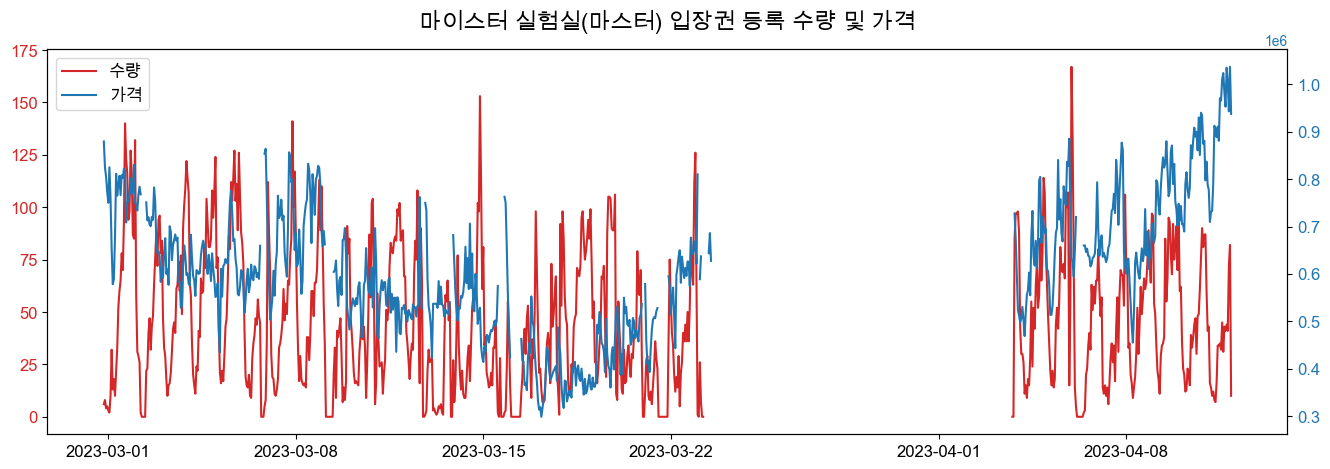

In [18]:
print_ticket_lineplot(11, 'regi')

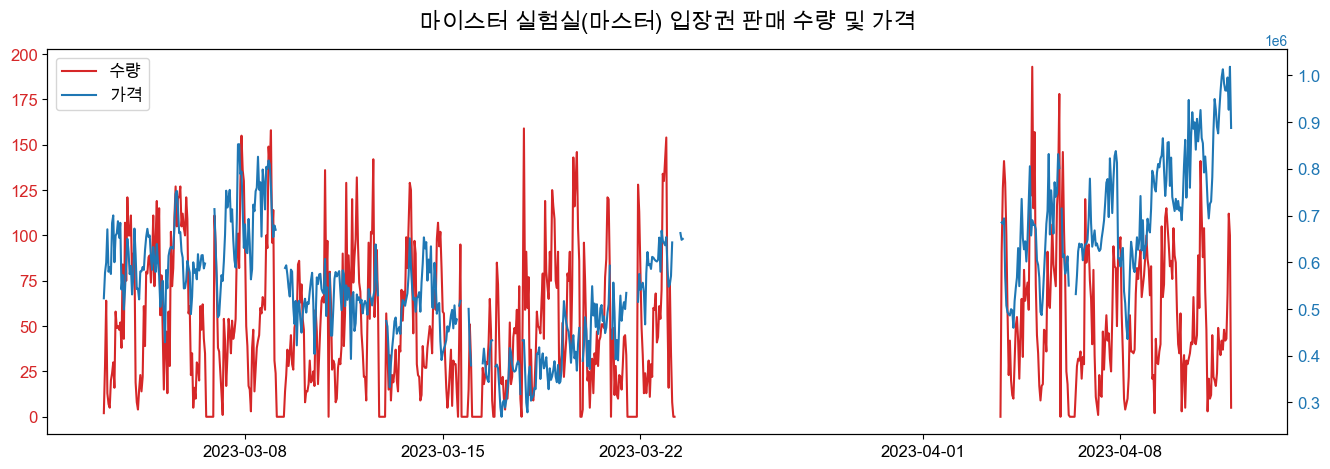

In [19]:
print_ticket_lineplot(11, 'sold')

### 추세 확인

- statsmodels - seasonal_decompose을 사용하여 추세를 확인해보려 했지만 가격에 대한 결측값 처리가 어려워 Prophet을 사용. 

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

# statsmodels - seasonal_decompose 수량에 대한 요약은 잘 나오지만 가격에 대한 결측치 처리를 직접해줘야 해서 사용하지 않음.
# 주 단위, 시간 단위 시계열 분해는 Prophet으로 확인하는게 더 간편해서 Prophet을 사용.

"""
def print_seasonal_decompose(df, target_col):
    if target_col == 'count':
        seasonal_df = df[target_col].resample('1H').sum()    
    elif target_col == 'unitPrice':
        seasonal_df = df[target_col].resample('1H').mean()
    
    seasonal_df = seasonal_df['2023-03-01 06:00:00':'2023-03-23 05:59:59']

    fig = seasonal_decompose(seasonal_df, extrapolate_trend = 'freq' , model='additive' ).plot()
    plt.show()
    return seasonal_df
"""

"\ndef print_seasonal_decompose(df, target_col):\n    if target_col == 'count':\n        seasonal_df = df[target_col].resample('1H').sum()    \n    elif target_col == 'unitPrice':\n        seasonal_df = df[target_col].resample('1H').mean()\n    \n    seasonal_df = seasonal_df['2023-03-01 06:00:00':'2023-03-23 05:59:59']\n\n    fig = seasonal_decompose(seasonal_df, extrapolate_trend = 'freq' , model='additive' ).plot()\n    plt.show()\n    return seasonal_df\n"

In [21]:
import prophet

In [22]:
# prophet을 사용하기 위한 데이터프레임 만들기 함수
def make_prophet_df(dataset, target_col, trade_type):

    # 가격, 수량에 맞춘 리샘플 데이터프레임 만들기
    if target_col == 'count':
        df = dataset[target_col].resample('1H').sum()
    elif target_col == 'unitPrice':
        df = dataset[target_col].resample('1H').mean()

    # prophet 모듈은 중간에 비어있는 기간이 있어 정확한 파악이 어려워 기간 분리
    # 23일 점검 전까지 데이터 사용
    df = df['2023-03-01 06:00:00':'2023-03-23 05:59:59']
    df = df.reset_index()

    # 등록, 판매에 맞추어 컬럼명 변경
    if trade_type == 'regi':
        df = df.rename(columns = {'regDate' : 'ds'})
    elif trade_type == 'sold':
        df = df.rename(columns = {'soldDate' : 'ds'})

    df = df.rename(columns = {target_col : 'y'})
    
    return df
    

In [23]:
# prophet을 사용하여 추세 그래프 출력
def print_item_components(df, target_col, auction_type):

    # prophet 사용하기 위한 데이터프레임 가져오기
    prophet_df = make_prophet_df(df, target_col, auction_type)

    # Prophet 모델 만들기 - 하이퍼파라미터는 GridSearchCV를 통해서 가장 잘 예측하는 값으로 사용.
    model = prophet.Prophet(
        changepoint_prior_scale = 0.1,
        seasonality_mode = 'multiplicative' ,
        seasonality_prior_scale = 12,
        weekly_seasonality = 17,
        daily_seasonality = 12,
        yearly_seasonality = False
    )

    # 데이터 모델 적용
    model.fit(prophet_df)
    
    # 추세 그래프를 그리기  위해 하루치 예측 데이터 만들기
    future = model.make_future_dataframe(periods=24, freq='H')

    # 예측 및 데이터에 대한 추세 그래프 그리기
    forecast = model.predict(future)
    model.plot_components(forecast)
    plt.show()
    return 

18:10:11 - cmdstanpy - INFO - Chain [1] start processing


regi 시계열 분해


18:10:11 - cmdstanpy - INFO - Chain [1] done processing


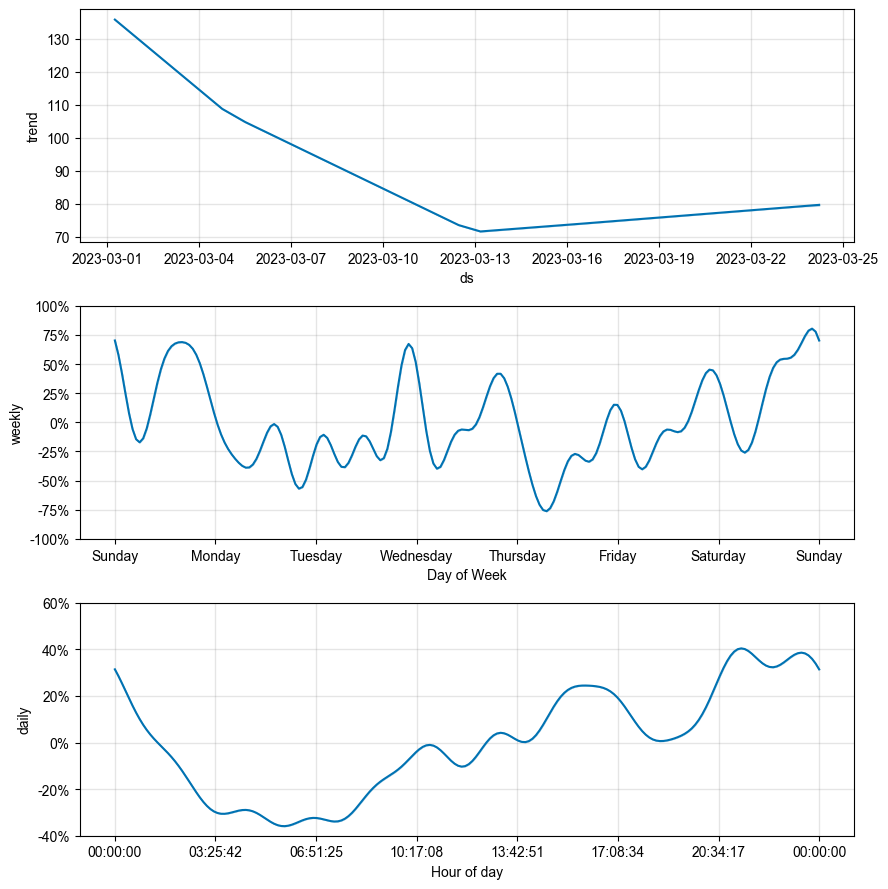

18:10:12 - cmdstanpy - INFO - Chain [1] start processing



sold 시계열 분해


18:10:12 - cmdstanpy - INFO - Chain [1] done processing


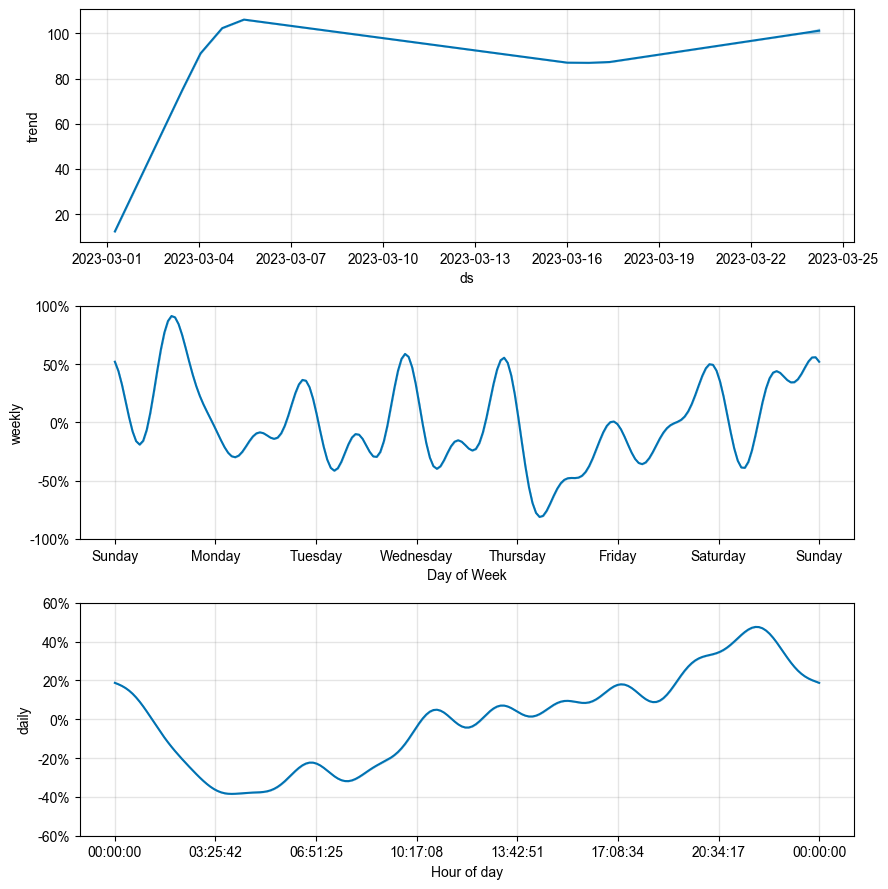

In [24]:
trade_dataset = {'regi' : regi_df, 'sold' : sold_df}

for trade_type, auction_df in trade_dataset.items():
    print(trade_type + " 시계열 분해")
    print_item_components(auction_df, 'count', trade_type)
    print()

### 골드 시세와 비교

In [25]:
# 아이템 매니아 골드 시세 가져오기 - xmltodict, selenium, webdriver_manager 모듈 설치 필요
def get_gold_trend():    
    
    # 크롤링 py 실행 -> gold_price.csv 생성
    !python get_gold_trend.py

    # 데이터 가져오기
    gold_price = pd.read_csv('gold_price.csv')

    #데이터 정리
    gold_price = gold_price.rename(columns={
    '@date' : 'date',
    '@price' : 'price'
    })

    gold_price['price'] = gold_price['price'].astype(int)

    gold_price = gold_price.drop(list(filter(lambda x : x not in ['date','price'], gold_price.columns)), axis=1)
    gold_price['date'] = pd.to_datetime(gold_price['date'])
    gold_price['price'] = gold_price['price'].astype(int)
    gold_price.set_index('date', inplace=True)

    return gold_price

In [26]:
# 골드 시세 가져오기 - 구글 크롬 드라이버 자동 설치됨.(약 10M)
gold_price = get_gold_trend()

[WDM] - Downloading: 100%|█████████████████| 8.79M/8.79M [00:00<00:00, 65.4MB/s]


In [27]:
# 골드 시세와 입장권 시각화
def print_gold_ticket(ticket_df, gold_df, daily_price, trade_type):

    # 등록과 판매의 데이터 시작일이 다름.
    # 판매 이력의 경우 판매 수량 자체가 적을 경우 API에서 받아오는 시작일이 좀 더 과거일 수 있기 떄문에 따로 설정.
    start_day = format((ticket_df.index.min())  - (datetime.timedelta(days=1)), '%Y-%m-%d')
    gold_df = gold_df[start_day:]

    # 그래프 그리기
    fig, ax1 = plt.subplots(figsize=(16,5))

    # 골드 가치 그래프
    color = 'tab:red'
    ax1.set_xlabel('date', fontsize = 15)
    ax1.set_ylabel('GOLD_VLAUE', fontsize = 15, color=color)
    ax1.plot(gold_df, color=color, label='골드 가치')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    # 입장권 가격 그래프
    color = 'tab:blue'
    color2 = 'xkcd:sky blue'
    ax2.set_ylabel('TICKET_PRICE', fontsize = 16, color=color) 
    ax2.scatter(x = ticket_df.index, y = ticket_df, color='skyblue', label='시간대 평균 가격') # 시간대 평균 가격 Scatter
    ax2.plot(daily_price, color='b', label='하루 평균 가격') # 하루 평균 가격 line
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='y', which='major', labelsize=12)
    

    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax2.set_ylabel('')

    trade_keyword = '판매' if trade_type == 'sold' else '등록'

    plt.title('골드 가치  -  마이스터 실험실 마스터 입장권 가격('+ trade_keyword + ')', fontsize=17, pad = 12)
    
    # 범례
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best', frameon=True)

    plt.show()

In [32]:
# 골드, 티켓 그래프 시각화 함수
# 데이터 프레임만 넘겨주면 시간별 가격, 하루 평균 가격으로 데이터프레임 만들어 시각화 함수에 전달
def compare_gold(ticket_price_df, gold_df, trade_type):

    # index : 11 -> 마이스터 실험실 마스터 입장권
    df_key = list(ticket_dfs[trade_type][11].keys())[0] # itemName정보 가져오기 key값으로 들고있음.

    df = ticket_dfs['regi'][11][df_key]

    ticket_price = df['unitPrice'].resample('1H').mean()
    daily_price = df[['unitPrice']].resample('1D').mean()
    
    now = time.localtime()
    today = time.strftime('%Y-%m-%d', now)
    gold_df = gold_df[: today]

    print_gold_ticket(ticket_price, gold_df, daily_price, trade_type)


REGIT TICKET AUCTION


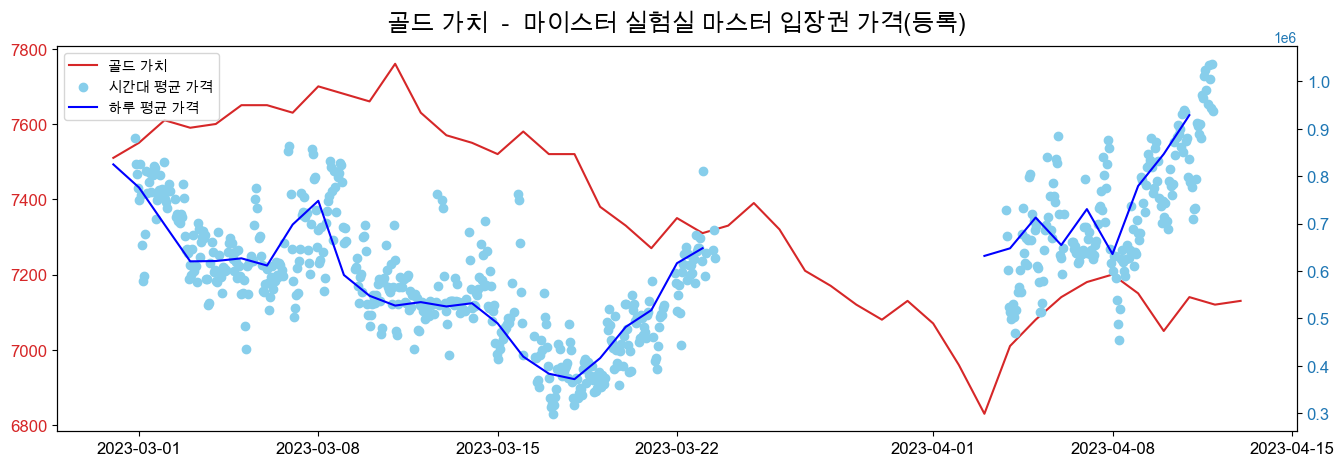


SOLD TICKET AUCTION


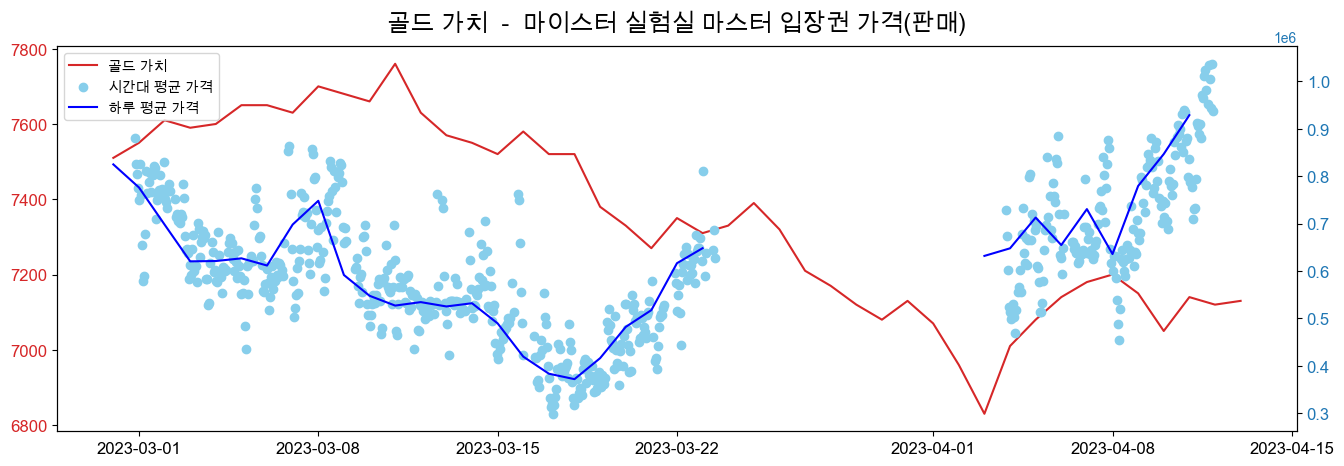

In [33]:
# 골드와 입장권 가격 정보 시각화
print('REGIT TICKET AUCTION')
compare_gold(regi_df, gold_price, "regi")
print()
print('SOLD TICKET AUCTION')
compare_gold(sold_df, gold_price, "sold")


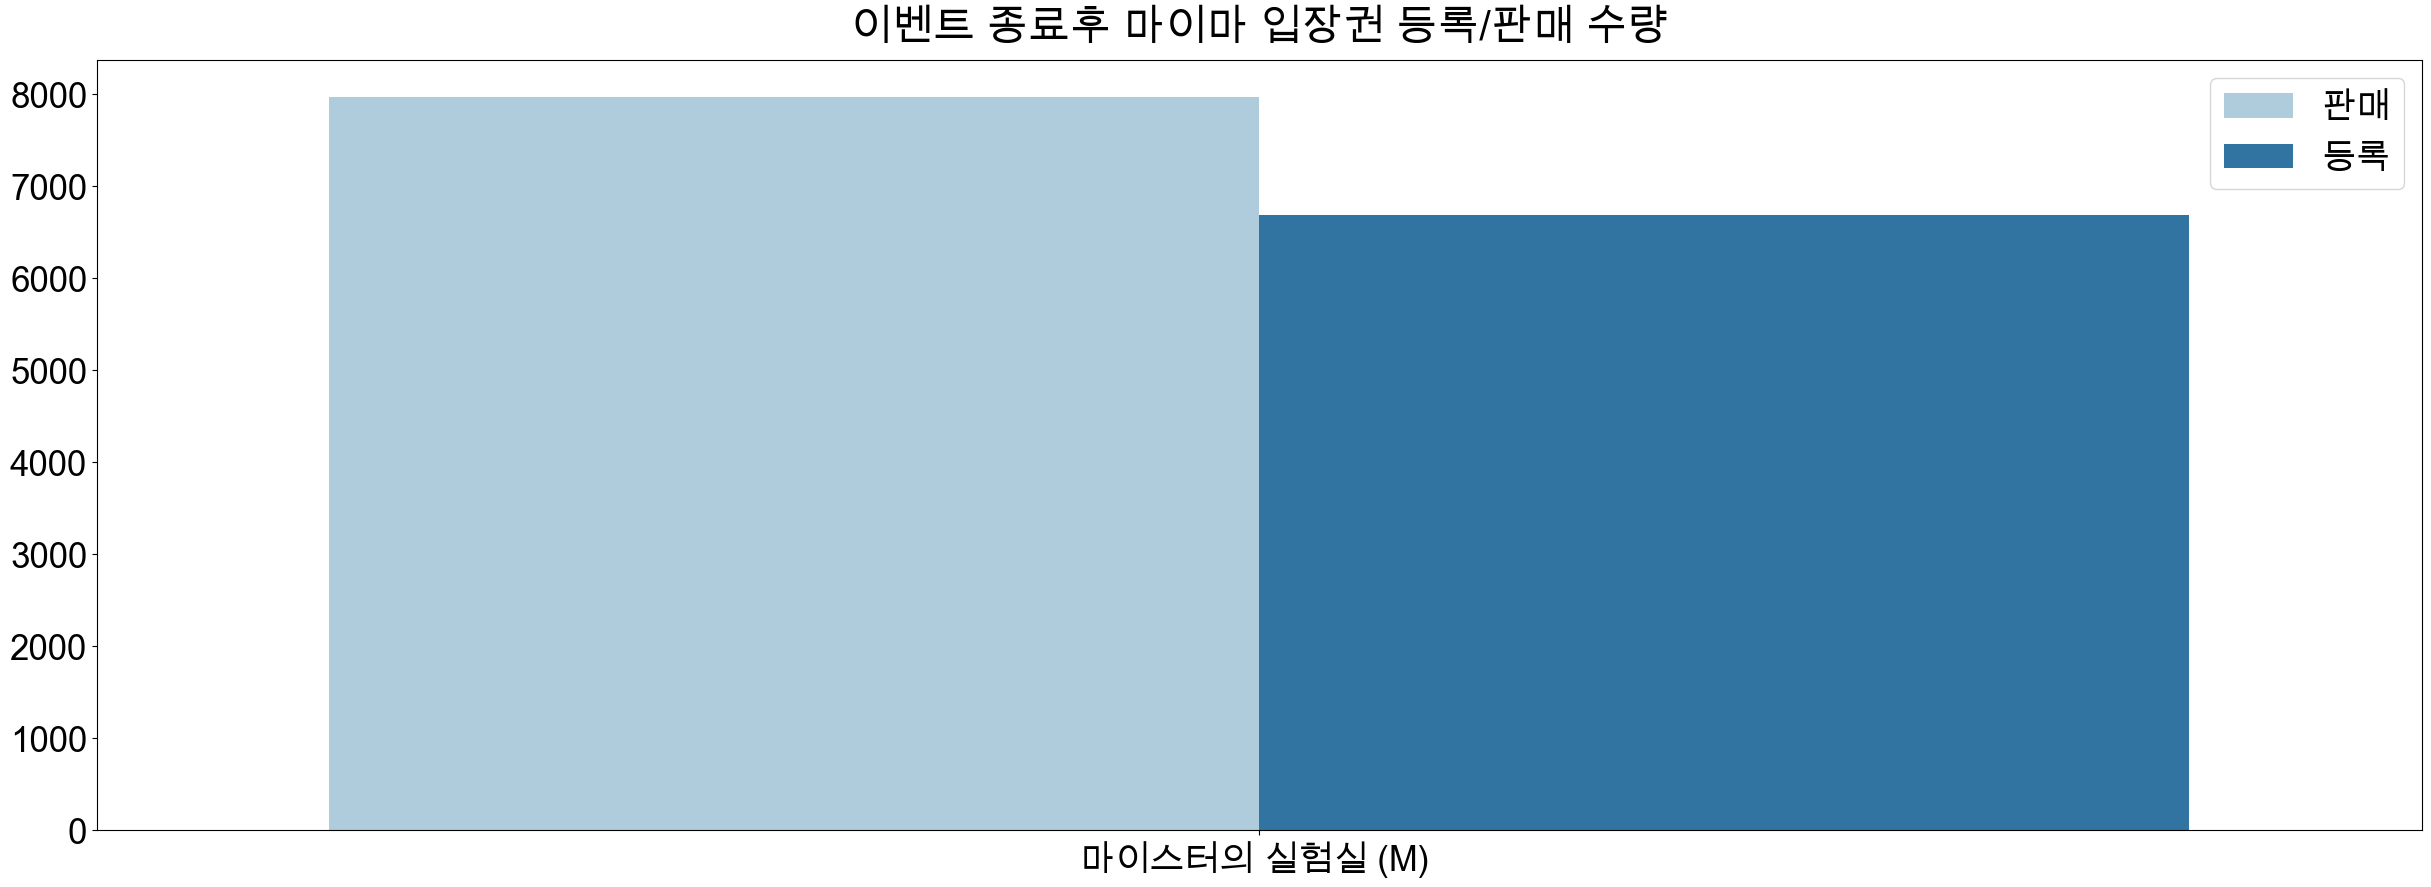

In [31]:
modify_sold_df = sold_df[sold_df.index > '2023-04-05']
modify_regi_df = regi_df[regi_df.index > '2023-04-05']

target = '마이스터의 실험실 (마스터) 입장권'
sold_flag = modify_sold_df['itemName'] == target
regi_flag = modify_regi_df['itemName'] == target

print_tickets(modify_sold_df[sold_flag], modify_regi_df[regi_flag], '이벤트 종료후 마이마 입장권 등록/판매 수량')